In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

In [129]:
df = pd.read_csv('data/heart.csv', sep = ',')

### Business Question?
### Predicting whether a patient will develop heart disease.


Features
```
Exploring Data
# patient data:

1 - Age: age of the patient [years]
2 - Sex: sex of the patient [M: Male, F: Female]
3 - ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4 - RestingBP: resting blood pressure [mm Hg]
5 - Cholesterol: serum cholesterol [mm/dl]
6 - FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7 - RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8 - MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9 - ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10 - Oldpeak: oldpeak = ST [Numeric value measured in depression]
12 - ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
13 - HeartDisease: output class [1: heart disease, 0: Normal]
```


In [130]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [132]:
df['Oldpeak'] = df['Oldpeak'].astype(int)

In [133]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.720044,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,0.990165,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.000000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.000000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.000000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.000000,1.000000


In [134]:
# identify all columns with null values.
null_columns = df.columns[df.isnull().any()].tolist()
print("Columns with null values:", null_columns)

# count null values
null_counts = df.isnull().sum()
print(null_counts)

Columns with null values: []
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [135]:
# counts and idenify all values within each features that do not have a number range such as MaxHR

sex_counts = df['Sex'].value_counts(dropna=False)
ChestPainType_counts = df['ChestPainType'].value_counts(dropna=False)
FastingBS_counts = df['FastingBS'].value_counts(dropna=False)
RestingECG_counts = df['RestingECG'].value_counts(dropna=False)
ExerciseAngina_counts = df['ExerciseAngina'].value_counts(dropna=False)
ST_Slope_counts = df['ST_Slope'].value_counts(dropna=False)
HeartDisease_counts = df['HeartDisease'].value_counts(dropna=False)

print(sex_counts)
print()
print(ChestPainType_counts)
print()
print(FastingBS_counts)
print()
print(RestingECG_counts)
print()
print(ExerciseAngina_counts)
print()
print(ST_Slope_counts)
print()
print(HeartDisease_counts)
print()



Sex
M    725
F    193
Name: count, dtype: int64

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

FastingBS
0    704
1    214
Name: count, dtype: int64

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

HeartDisease
1    508
0    410
Name: count, dtype: int64



In [136]:
# select min and max values of features with number range such as MaxHR

max_value = df['Age'].max()
min_value = df['Age'].min()
print(f"Age Max Value: {max_value}")
print(f"Age Min Value: {min_value}")
print()

max_value = df['RestingBP'].max()
min_value = df['RestingBP'].min()
print(f"RestingBP Max Value: {max_value}")
print(f"RestingBP Min Value: {min_value}")
print()

max_value = df['Cholesterol'].max()
min_value = df['Cholesterol'].min()
print(f"Cholesterol Max Value: {max_value}")
print(f"Cholesterol Min Value: {min_value}")
print()

max_value = df['MaxHR'].max()
min_value = df['MaxHR'].min()
print(f"MaxHR Max Value: {max_value}")
print(f"MaxHR Min Value: {min_value}")
print()

max_value = df['Oldpeak'].max()
min_value = df['Oldpeak'].min()
print(f"Oldpeak Max Value: {max_value}")
print(f"Oldpeak Min Value: {min_value}")


Age Max Value: 77
Age Min Value: 28

RestingBP Max Value: 200
RestingBP Min Value: 0

Cholesterol Max Value: 603
Cholesterol Min Value: 0

MaxHR Max Value: 202
MaxHR Min Value: 60

Oldpeak Max Value: 6
Oldpeak Min Value: -2


In [137]:
# RestingBP and Cholestorl appears to have 0 as values. will set as NULL and drop rows as to not skew the data.
df['RestingBP'] = df['RestingBP'].replace(0, pd.NA)
df['Cholesterol'] = df['Cholesterol'].replace(0, pd.NA)
df = df.dropna()

max_value = df['RestingBP'].max()
min_value = df['RestingBP'].min()
print(f"RestingBP Max Value: {max_value}")
print(f"RestingBP Min Value: {min_value}")
print()

max_value = df['Cholesterol'].max()
min_value = df['Cholesterol'].min()
print(f"Cholesterol Max Value: {max_value}")
print(f"Cholesterol Min Value: {min_value}")
print()



RestingBP Max Value: 200
RestingBP Min Value: 92

Cholesterol Max Value: 603
Cholesterol Min Value: 85



In [138]:
df.describe()

,Age,FastingBS,MaxHR,Oldpeak,HeartDisease
count,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,0.167560,140.226542,0.730563,0.477212
std,9.505888,0.373726,24.524107,1.002576,0.499816
min,28.000000,0.000000,69.000000,0.000000,0.000000
25%,46.000000,0.000000,122.000000,0.000000,0.000000
50%,54.000000,0.000000,140.000000,0.000000,0.000000
75%,59.000000,0.000000,160.000000,1.000000,1.000000
max,77.000000,1.000000,202.000000,6.000000,1.000000


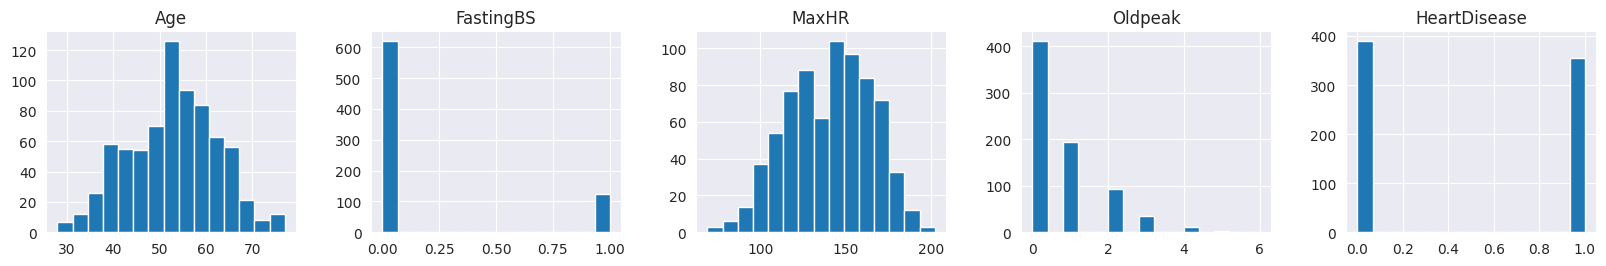

In [139]:
df.hist(bins=15, figsize=(20, 6), layout=(2, 5))
plt.show()

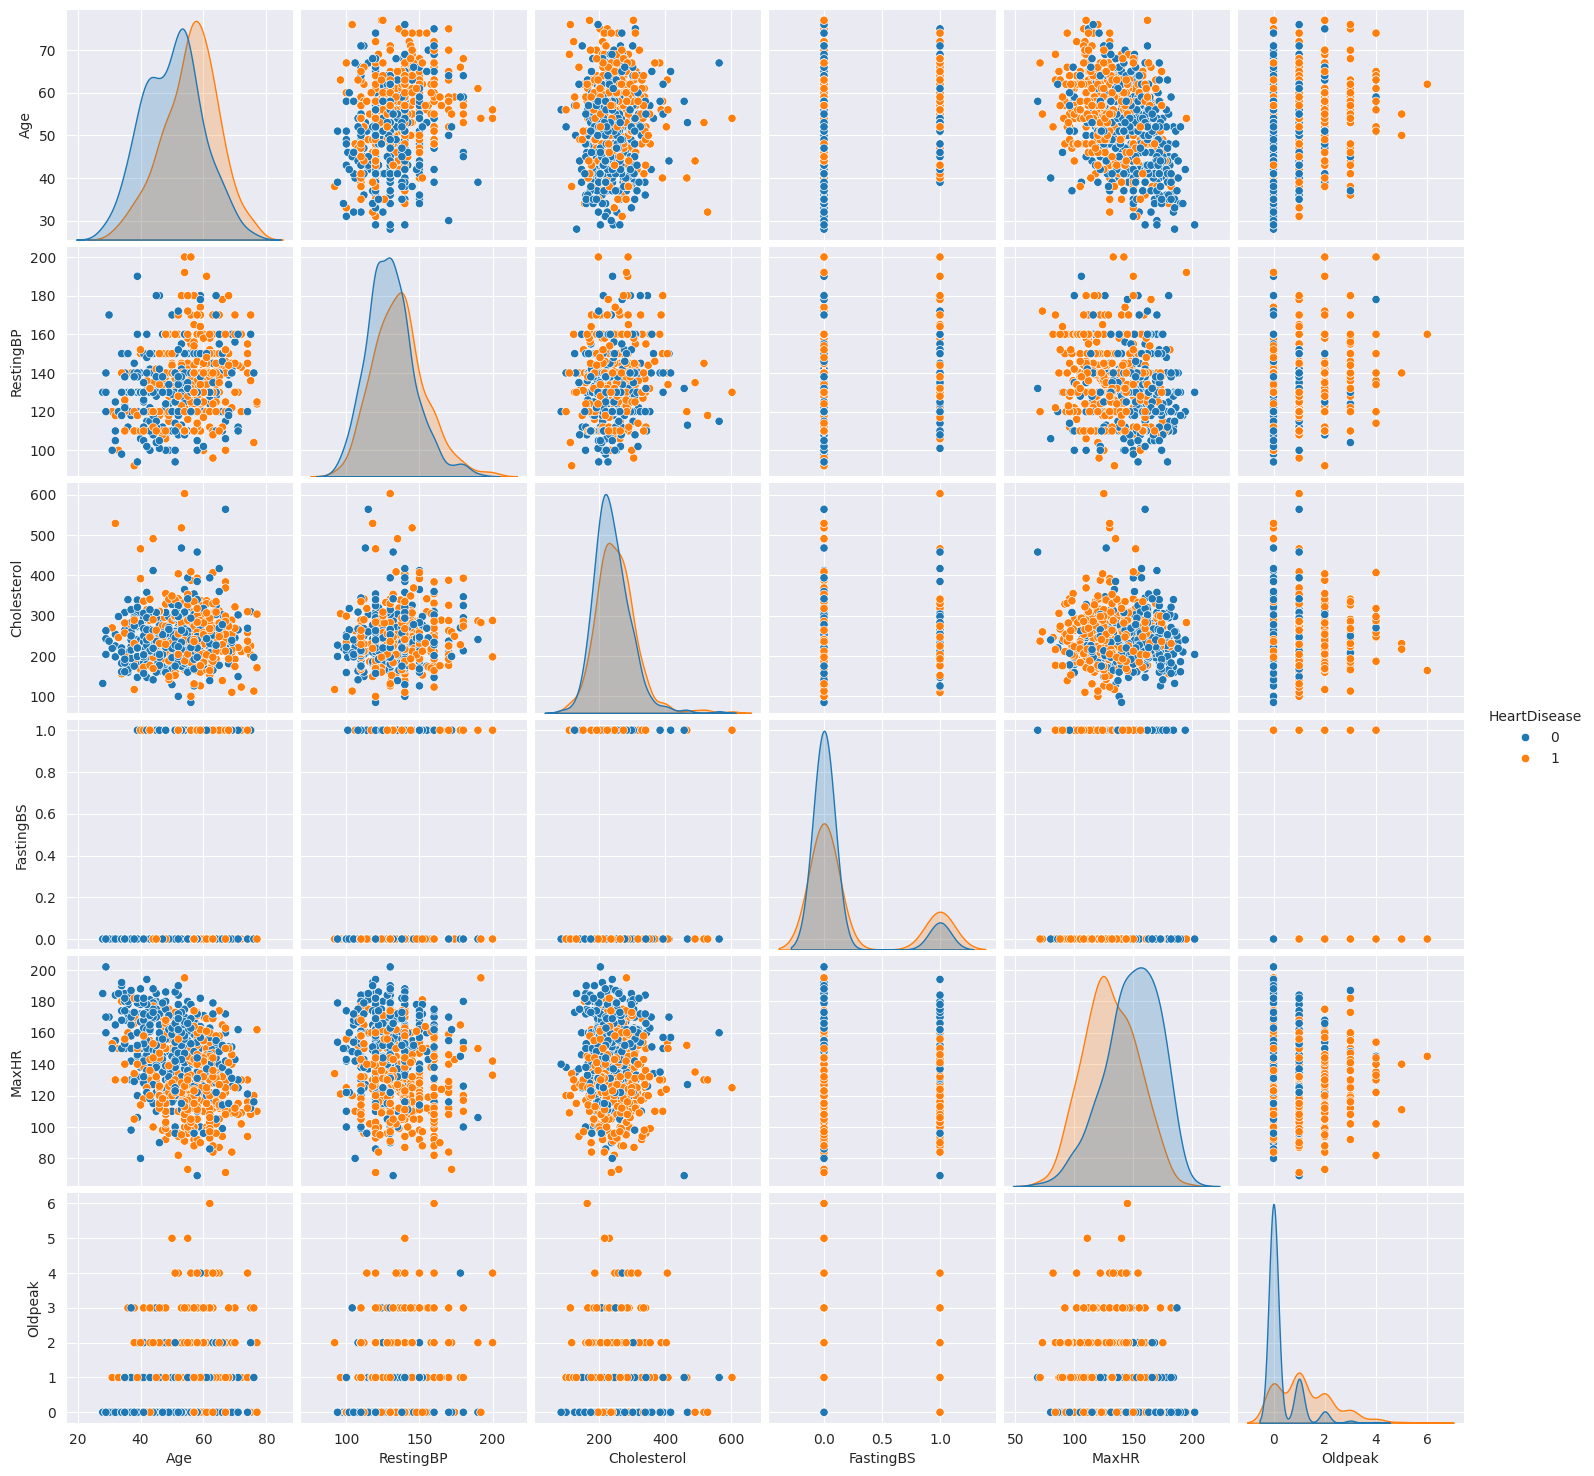

In [140]:
sns.pairplot(df, hue="HeartDisease")
plt.show()

Engineering Features

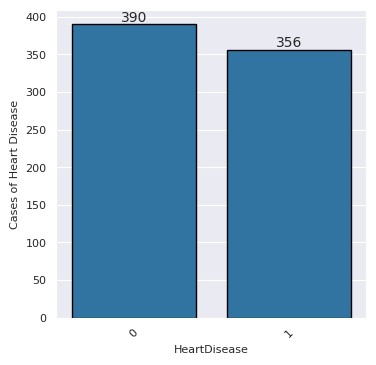

In [141]:

# based on graph. our dataset is balanced.

plt.figure(figsize = (4, 4))
ax=sns.countplot(data=df, x=df.HeartDisease, ec='black')
sns.set_style('darkgrid')
for cont in ax.containers:
    ax.bar_label(cont)
plt.ylabel('Cases of Heart Disease', size=8)
plt.yticks(size=8)
plt.xlabel('HeartDisease', size=8)
plt.xticks(size=8)
plt.xticks(rotation=45)
plt.show()
pd.reset_option('display.max_columns', 0)




<Axes: >

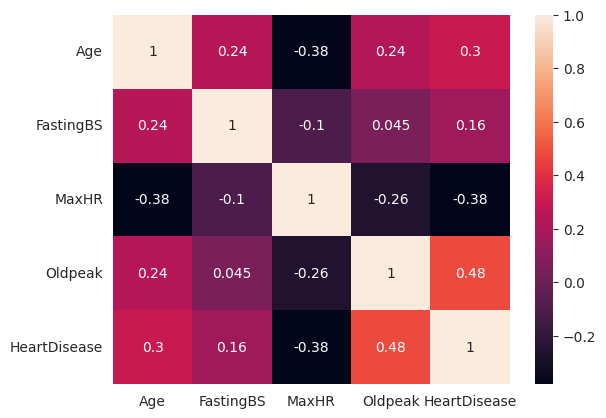

In [142]:
# Idenfity fields to see what highest correlation to heart disease.
# Correlations to heart disease shows that Old Peak and Age are the two features that are most related to heart disease.

corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

In [143]:
# Define features (X) and target (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Select features by datatype.
# Scale and encode transformation.
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer((OneHotEncoder(drop = 'first', handle_unknown="ignore"), selector),
                                     remainder = StandardScaler())
# ----------------------------------------------------------------------------------
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ])



In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [145]:
print(f"Training set size: {X_train.shape}. Training labels size: {y_train.shape}")
print(f"Test set size: {X_test.shape}. Test labels size: {y_test.shape}")

Training set size: (596, 11). Training labels size: (596,)
Test set size: (150, 11). Test labels size: (150,)


<Figure size 400x300 with 0 Axes>

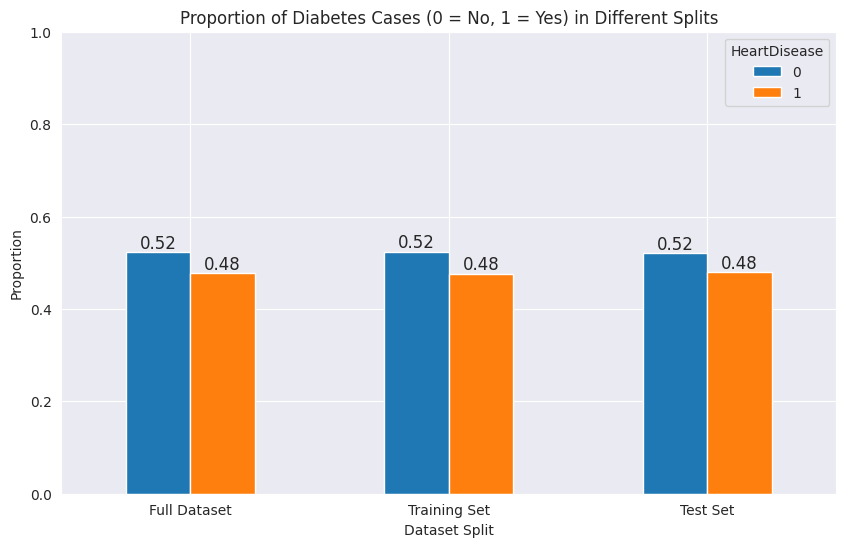

In [146]:
y_distribution_df = pd.DataFrame({
    'Full Dataset': df['HeartDisease'].value_counts(normalize=True),
    'Training Set': y_train.value_counts(normalize=True),
    'Test Set': y_test.value_counts(normalize=True)
}).T

plt.figure(figsize=(4, 3))
ax = y_distribution_df.plot(kind='bar', figsize=(10, 6), rot=0)

plt.title("Proportion of Diabetes Cases (0 = No, 1 = Yes) in Different Splits")
plt.xlabel("Dataset Split")
plt.ylabel("Proportion")
plt.legend(title="HeartDisease")
plt.ylim(0, 1)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12)

plt.show()

In [147]:
# Similar to the bar chart above, the dataset is balanced.
y_test.value_counts(normalize = True)

,proportion
HeartDisease,
0,0.52
1,0.48


Modeling

Baseline Accuracy: 0.52
Baseline Precision: 0.50
Baseline Recall: 0.54
Baseline F1 Score: 0.52


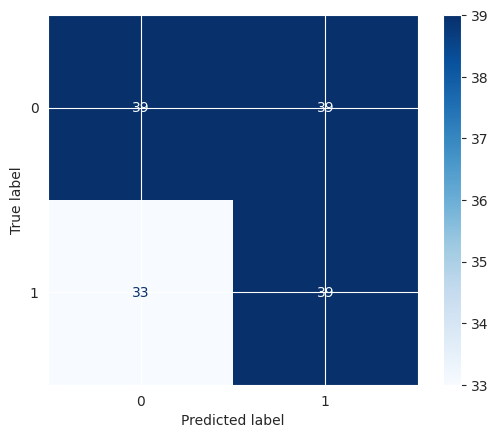

In [148]:
random_baseline = DummyClassifier(strategy='stratified') # most_frequent for majority guess
random_baseline.fit(X_train, y_train)
y_random_pred = random_baseline.predict(X_test)

# Calculate baseline metrics
accuracy_baseline = accuracy_score(y_test, y_random_pred)
precision_baseline = precision_score(y_test, y_random_pred, average='binary', zero_division=0)
recall_baseline = recall_score(y_test, y_random_pred, average='binary', zero_division=0)
f1_baseline = f1_score(y_test, y_random_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_test, y_random_pred)

print(f"Baseline Accuracy: {accuracy_baseline:.2f}")
print(f"Baseline Precision: {precision_baseline:.2f}")
print(f"Baseline Recall: {recall_baseline:.2f}")
print(f"Baseline F1 Score: {f1_baseline:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [149]:
# Based on the accuracy score KNN is the best model to use as it has the highest Accuracy, Precision, Recall, and F1 score.
results = []

# Calculate knn metrics
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall_knn = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1_knn = f1_score(y_test, y_pred, average='binary', zero_division=0)
results.append({
   "Model": 'KNN',
   "Accuracy": accuracy_knn,
   "Precision": precision_knn,
   "Recall": recall_knn,
   "F1": f1_knn,
})


# Calculate logisticregression metrics
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy_logisticregression = accuracy_score(y_test, y_pred)
precision_logisticregression = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall_logisticregression = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1_logisticregression = f1_score(y_test, y_pred, average='binary', zero_division=0)
results.append({
   "Model": 'Logistic Regression',
   "Accuracy": accuracy_logisticregression,
   "Precision": precision_logisticregression,
   "Recall": recall_logisticregression,
   "F1": f1_logisticregression,
})


# Calculate SVC metrics
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy_SVC = accuracy_score(y_test, y_pred)
precision_SVC = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall_SVC = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1_SVC = f1_score(y_test, y_pred, average='binary', zero_division=0)
results.append({
   "Model": 'SVC',
   "Accuracy": accuracy_SVC,
   "Precision": precision_SVC,
   "Recall": recall_SVC,
   "F1": f1_SVC,
})


# Calculate DecisionTreeClassifier metrics
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy_DecisionTreeClassifier = accuracy_score(y_test, y_pred)
precision_DecisionTreeClassifier = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall_DecisionTreeClassifier = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1_DecisionTreeClassifier = f1_score(y_test, y_pred, average='binary', zero_division=0)
results.append({
   "Model": 'Decision Tree',
   "Accuracy": accuracy_DecisionTreeClassifier,
   "Precision": precision_DecisionTreeClassifier,
   "Recall": recall_DecisionTreeClassifier,
   "F1": f1_DecisionTreeClassifier
})

# Calculate RandomForestClassifier metrics
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy_RandomForestClassifier = accuracy_score(y_test, y_pred)
precision_RandomForestClassifier = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall_RandomForestClassifier = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1_RandomForestClassifier = f1_score(y_test, y_pred, average='binary', zero_division=0)
results.append({
   "Model": 'Random Forest',
   "Accuracy": accuracy_RandomForestClassifier,
   "Precision": precision_RandomForestClassifier,
   "Recall": recall_RandomForestClassifier,
   "F1": f1_RandomForestClassifier
})

# Calculate GradientBoostingClassifier metrics
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy_GradientBoostingClassifier = accuracy_score(y_test, y_pred)
precision_GradientBoostingClassifier = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall_GradientBoostingClassifier = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1_GradientBoostingClassifier = f1_score(y_test, y_pred, average='binary', zero_division=0)
results.append({
   "Model": 'Gradient Boosting',
   "Accuracy": accuracy_GradientBoostingClassifier,
   "Precision": precision_GradientBoostingClassifier,
   "Recall": recall_GradientBoostingClassifier,
   "F1": f1_GradientBoostingClassifier
})

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1
4,Random Forest,0.886667,0.876712,0.888889,0.882759
0,KNN,0.873333,0.873239,0.861111,0.867133
1,Logistic Regression,0.853333,0.837838,0.861111,0.849315
2,SVC,0.853333,0.828947,0.875000,0.851351
5,Gradient Boosting,0.840000,0.815789,0.861111,0.837838
3,Decision Tree,0.813333,0.814286,0.791667,0.802817


In [150]:
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]}),
    'randomforestclassifier': (RandomForestClassifier(), {'randomforestclassifier__n_estimators': [100, 200, 300]}),
    'gradientboostingclassifier': (GradientBoostingClassifier(), {'gradientboostingclassifier__n_estimators': [100, 200, 300]})}

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Compute performance metrics on train and test sets
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    y_test_pred = grid_search.best_estimator_.predict(X_test)

    # Evaluate on training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='binary', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='binary', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='binary', zero_division=0)

    # Compute test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='binary', zero_division=0)

    # Append the results
    results.append({
        "Model": name,
        "Best Params": grid_search.best_params_,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1": train_f1,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1": test_f1,
    })

# Create the results DataFrame
results_hyper = pd.DataFrame(results)
results_hyper.sort_values(by="Test F1", ascending=False)
# Based on comparison using tuning the classifers for each model.


,Model,Best Params,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
4,randomforestclassifier,{'randomforestclassifier__n_estimators': 200},1.000000,1.000000,1.000000,1.000000,0.880000,0.864865,0.888889,0.876712
1,logisticregression,{'logisticregression__C': 0.1},0.870805,0.858131,0.873239,0.865620,0.860000,0.840000,0.875000,0.857143
0,knn,{'knn__n_neighbors': 7},0.889262,0.873288,0.897887,0.885417,0.860000,0.849315,0.861111,0.855172
2,svc,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.912752,0.886667,0.936620,0.910959,0.853333,0.828947,0.875000,0.851351
5,gradientboostingclassifier,{'gradientboostingclassifier__n_estimators': 200},0.969799,0.952381,0.985915,0.968858,0.840000,0.815789,0.861111,0.837838
3,decisiontreeclassifier,{'decisiontreeclassifier__max_depth': 15},0.993289,0.989510,0.996479,0.992982,0.826667,0.819444,0.819444,0.819444


Selecting the best model (Random Forrest)

In [151]:
models = {
    'randomforestclassifier': (RandomForestClassifier(), {'randomforestclassifier__n_estimators': [100, 200, 300]})}

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Compute performance metrics on train and test sets
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    y_test_pred = grid_search.best_estimator_.predict(X_test)

    # Evaluate on training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='binary', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='binary', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='binary', zero_division=0)

    # Compute test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='binary', zero_division=0)

best_model.get_params()


{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    ['Age', 'FastingBS', 'MaxHR', 'Oldpeak']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['Sex', 'ChestPainType', 'RestingBP',
                                     'Cholesterol', 'RestingECG', 'ExerciseAngina',
                                     'ST_Slope'])])),
  ('randomforestclassifier', RandomForestClassifier(n_estimators=200))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  ['Age', 'FastingBS', 'MaxHR', 'Oldpeak']),
                                 ('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['Sex', 'ChestPainType', 'RestingBP',
                                   'Cholesterol', 'RestingECG', 'ExerciseAngina',
               

In [152]:
best_model_pred_y_train = best_model.predict(X_train)
best_model_pred_y_test = best_model.predict(X_test)
rf = best_model.fit(X_train, y_train)

Train set
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


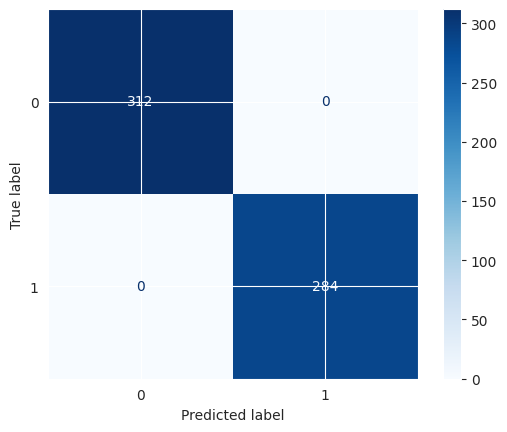

In [153]:
# Calculate metrics on train set
accuracy_train = accuracy_score(y_train, best_model_pred_y_train)
precision_train = precision_score(y_train, best_model_pred_y_train, average='binary', zero_division=0)
recall_train = recall_score(y_train, best_model_pred_y_train, average='binary', zero_division=0)
f1_train = f1_score(y_train, best_model_pred_y_train, average='binary', zero_division=0)
cm_train = confusion_matrix(y_train, best_model_pred_y_train)

print(f"Train set")
print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Recall: {recall_train:.2f}")
print(f"F1 Score: {f1_train:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.show()

Test set
Accuracy: 0.87
Precision: 0.84
Recall: 0.89
F1 Score: 0.86


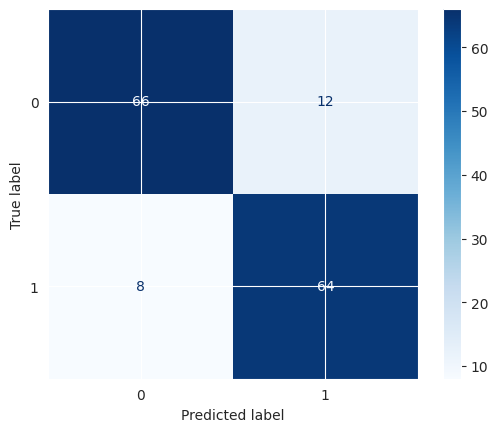

In [154]:
# Calculate metrics on test set
accuracy_test = accuracy_score(y_test, best_model_pred_y_test)
precision_test = precision_score(y_test, best_model_pred_y_test, average='binary', zero_division=0)
recall_test = recall_score(y_test, best_model_pred_y_test, average='binary', zero_division=0)
f1_test = f1_score(y_test, best_model_pred_y_test, average='binary', zero_division=0)
cm_test = confusion_matrix(y_test, best_model_pred_y_test)

print(f"Test set")
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"F1 Score: {f1_test:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.show()

The model correctly classifies 88% of cases for what would be new data, which is good and is a huge improvement from the baseline accuracy of 52%. The model here has a higher recall which means it identifies 89% of actual heart disease outcomes correctly. precision and F1 score is still in the mid 80s%, which a good direction of this model.

Improving the Model

In [159]:
models = {
    'randomforestclassifier': (RandomForestClassifier(), {'randomforestclassifier__n_estimators': [100, 200, 300]})}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforestclassifier', model)
])

# Fit the pipeline
pipeline.fit(X, y)

# Access the Random Forest model from the pipeline
rf_model = pipeline.named_steps['randomforestclassifier']  # 'rf' is the name of the Random Forest step

# Get feature importances
feature_importances = rf_model.feature_importances_

# Retrieve transformed feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Combine feature names with importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

pd.set_option('display.max_rows', 25)
print(importance_df.head(25))


                    Feature  Importance
301        cat__ST_Slope_Up    0.122763
300      cat__ST_Slope_Flat    0.117939
2                num__MaxHR    0.069254
0                  num__Age    0.063905
298   cat__ExerciseAngina_Y    0.054757
6    cat__ChestPainType_ASY    0.052484
297   cat__ExerciseAngina_N    0.051509
3              num__Oldpeak    0.048542
7    cat__ChestPainType_ATA    0.026727
4                cat__Sex_F    0.022399
5                cat__Sex_M    0.021680
8    cat__ChestPainType_NAP    0.015175
294     cat__RestingECG_LVH    0.011844
295  cat__RestingECG_Normal    0.011798
1            num__FastingBS    0.011089
38       cat__RestingBP_130    0.009109
299      cat__ST_Slope_Down    0.008758
296      cat__RestingECG_ST    0.007896
29       cat__RestingBP_120    0.007518
48       cat__RestingBP_140    0.007382
9     cat__ChestPainType_TA    0.006342
21       cat__RestingBP_110    0.006321
56       cat__RestingBP_150    0.006215
32       cat__RestingBP_124    0.004431


The top features that contribution likely to develop heart disease are ST_Slope (exercising), Age, Chest Piain Type, Exercise-induced angina.

##Main takeaways
The model that performs the best is Random Forest at predicting heart disease with accuracy rate of 88% and a recall rate of 89%. We also have a relatively high precision and F1 scores which indicates a model taht excels at correctly identifying positive instances while minimizing false positives.

Identified main features that should be focused on are ST_Slope (exercising), Age, Chest Piain Type, Exercise-induced angina.
Our model will be able to in health clinics and hospitals to flag high-risk patients before developing or worsening through
1) Preventive Care: Strategies designed to catch issues early or prevent them altogether.
or
2) Proactive Monitoring: disease management/ assessments aimed at catching complications early.

##Conclusion:

Patient who don't exerercise as frequent and older patients should be more aware of habits in their daily living. Although age is not controllable and should be monitor more closely as age climbs, the patient in general should be focusing on exercising and be aware of the type of check pains they are experiencing.

##Future Improvements
Track patients over time and predict the progression of heart disease.
Also look at other factors/features that may help increase our model accuract rates.